### Calculating ratio of time spent in classical communication vs quantum communications

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Moves one directory up
sys.path.append(project_root)

from analytical_solution.monte_carlo import monte_carlo

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#First we define all the deterministic variables

q = 0.7
k = 0.5

def p_l(L):
    p_0 = 0.0018
    return p_0*10**((-0.2*L)/10)

c = 299792.458/1.4585 

t_ent = 123e-6
t_swap = 2157e-6
t_fusion = 300e-6

vertices = 5
segments = vertices - 1
sim_count = 10000

Using some simple linear algebra, we can find the ratio of time spent in classical vs quantum as a function of the number of operations.

In [3]:
def classical_to_quantum_ratio(l, epsilon, sigma, kappa):
    classical_contribution = epsilon*(2*vertices*(l/c) + (l/c)) + sigma*(2*(vertices-1)*(l/c)) 
    quantum_contribution = epsilon*(t_ent) + sigma*(t_swap) + kappa*(t_ent)
    return classical_contribution, quantum_contribution

In [4]:
distances = np.arange(1, 11, 1)

sim_classical = np.zeros(shape=(len(distances), 2))
sim_quantum = np.zeros(shape=(len(distances), 2))


for i, dist in enumerate(distances):
    p = p_l(dist)
    _, e_all, p_all, k_all = monte_carlo(segments, sim_count, sim_count, p, q, k, ind = True)
    data = np.array([e_all, p_all, k_all]).mean(axis = 1)
    data_std = np.array([e_all, p_all, k_all]).std(axis = 1)

    unoptimised_classical, unoptimised_quantum = classical_to_quantum_ratio(dist, data[0], data[1], data[2])
    unoptimised_classical_err, unoptimised_quantum_err = classical_to_quantum_ratio(dist, data_std[0], data_std[1], data_std[2])

    sim_classical[i, 0] = unoptimised_classical
    sim_classical[i, 1] = unoptimised_classical_err
    sim_quantum[i, 0] = unoptimised_quantum
    sim_quantum[i, 1] = unoptimised_quantum_err

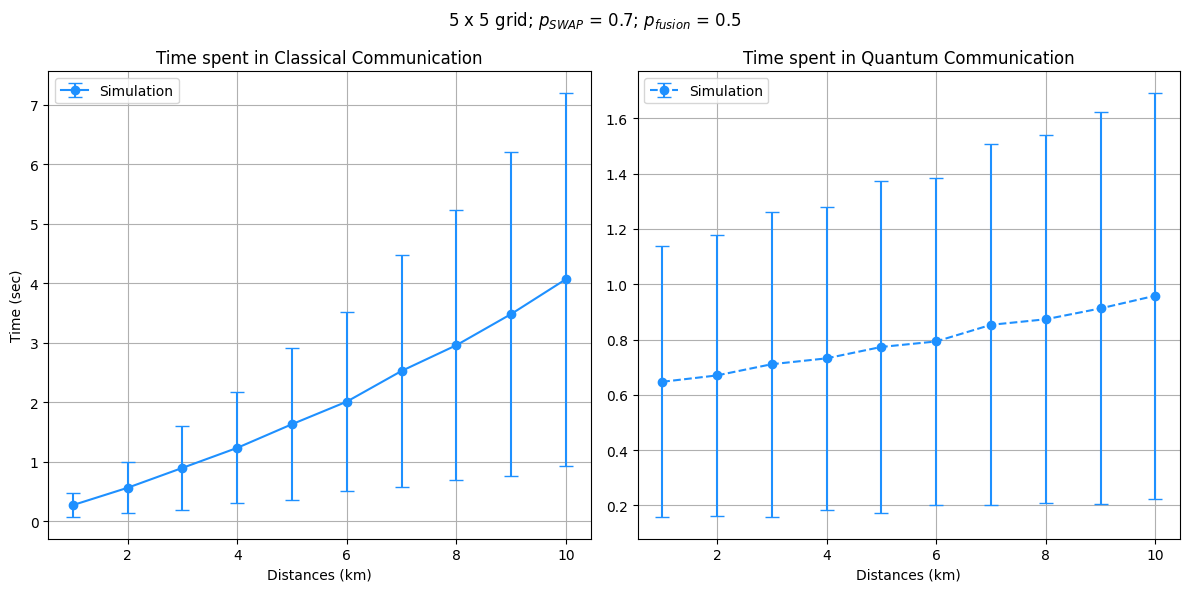

In [5]:
# Calculate the relative difference: (Classical - Qamel) / Classical
ratio = (sim_classical[:,0] - sim_quantum[:,0]) / sim_classical[:,0]

# Add a third subplot for the relative difference
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# First subplot - Classical Communication
axes[0].errorbar(distances, sim_classical[:,0], yerr=sim_classical[:,1], fmt='o-', color='dodgerblue', label="Simulation", capsize=5)
axes[0].set_title("Time spent in Classical Communication")
axes[0].set_xlabel("Distances (km)")
axes[0].set_ylabel("Time (sec)")
axes[0].legend()
axes[0].grid(True)

# Second subplot - Qamel Communication
axes[1].errorbar(distances, sim_quantum[:,0], yerr=sim_quantum[:,1], fmt='o--', color='dodgerblue', label="Simulation", capsize=5)
axes[1].set_title("Time spent in Quantum Communication")
axes[1].set_xlabel("Distances (km)")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plot
plt.suptitle(fr"{vertices} x {vertices} grid; $p_{{SWAP}}$ = {q}; $p_{{fusion}}$ = {k}")
plt.tight_layout()
plt.show()

Now we can introduce our agent and see if it does any better

In [6]:
#Running in agent_latencies.py as it connects to GPU.

qamel_count = np.loadtxt("S:/Anuj/University College London/Latency for MED protocols/Timing-Multiuser-Protocols/qamel/outputs/results/qamel_results.txt")
qamel_count_err = np.loadtxt("S:/Anuj/University College London/Latency for MED protocols/Timing-Multiuser-Protocols/qamel/outputs/results/qamel_results_err.txt")

qamel_results_classical = np.zeros(shape=(len(distances), 2))
qamel_results_quantum = np.zeros(shape=(len(distances), 2))

for j, dist in enumerate(distances):
    qamel_classical, qamel_quantum = classical_to_quantum_ratio(dist, qamel_count[j, 0], qamel_count[j, 1], qamel_count[j, 2])
    qamel_classical_err, qamel_quantum_err = classical_to_quantum_ratio(dist, qamel_count_err[j, 0], qamel_count_err[j, 1], qamel_count_err[j, 2])

    qamel_results_classical[j, 0] = qamel_classical
    qamel_results_classical[j, 1] = qamel_classical_err
    qamel_results_quantum[j, 0] = qamel_quantum
    qamel_results_quantum[j, 1] = qamel_quantum_err
    

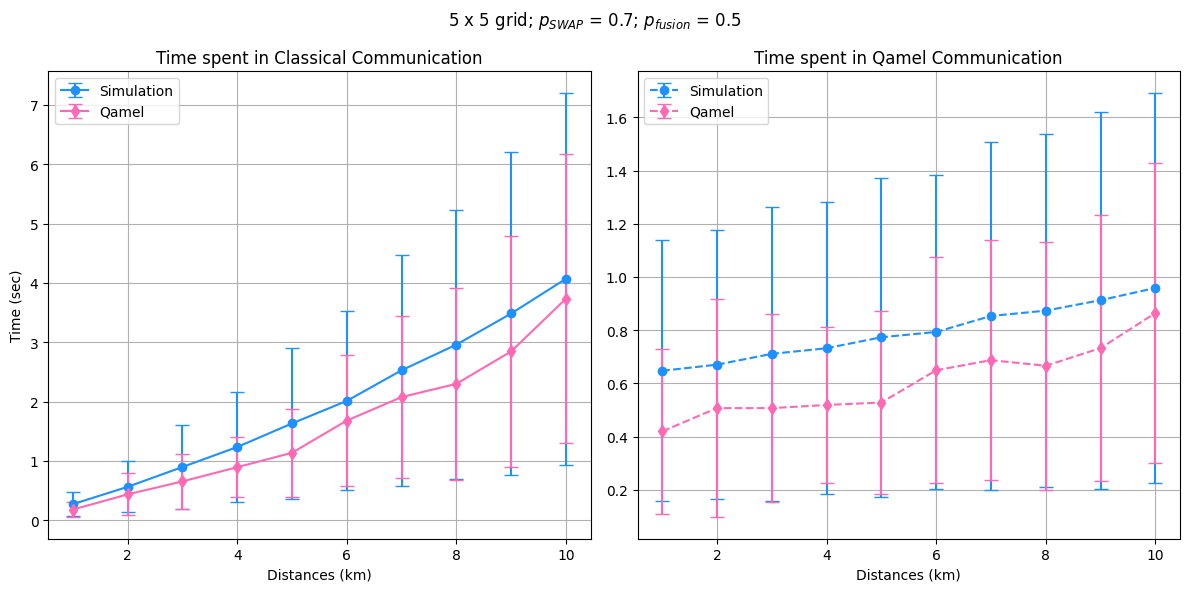

In [7]:
# Add a third subplot for the relative difference
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# First subplot - Classical Communication
axes[0].errorbar(distances, sim_classical[:,0], yerr=sim_classical[:,1], fmt='o-', color='dodgerblue', label="Simulation", capsize=5)
axes[0].errorbar(distances, qamel_results_classical[:,0], yerr=qamel_results_classical[:,1], fmt='d-', color='hotpink', label="Qamel", capsize=5)
axes[0].set_title("Time spent in Classical Communication")
axes[0].set_xlabel("Distances (km)")
axes[0].set_ylabel("Time (sec)")
axes[0].legend()
axes[0].grid(True)

# Second subplot - Qamel Communication
axes[1].errorbar(distances, sim_quantum[:,0], yerr=sim_quantum[:,1], fmt='o--', color='dodgerblue', label="Simulation", capsize=5)
axes[1].set_title("Time spent in Qamel Communication")
axes[1].errorbar(distances, qamel_results_quantum[:,0], yerr=qamel_results_quantum[:,1], fmt='d--', color='hotpink', label="Qamel", capsize=5)
axes[1].set_xlabel("Distances (km)")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plot
plt.suptitle(fr"{vertices} x {vertices} grid; $p_{{SWAP}}$ = {q}; $p_{{fusion}}$ = {k}")
plt.tight_layout()
plt.show()

In [8]:
#Raw rate

distances = np.arange(1, 11, 1)

simulation_results = np.zeros(shape=(2, len(distances), 3))
qamel_results = np.zeros(shape=(2, len(distances), 3))


for i, dist in enumerate(distances):
    p = p_l(dist)
    _, e_all, p_all, k_all = monte_carlo(segments, sim_count, sim_count, p, q, k, ind = True)
    data = np.array([e_all, p_all, k_all]).mean(axis = 1)
    data_std = np.array([e_all, p_all, k_all]).std(axis = 1)

    simulation_results[0, i] = data
    simulation_results[1, i] = data_std

    qamel_results[0, i] = qamel_count[i]
    qamel_results[1, i] = qamel_count_err[i]


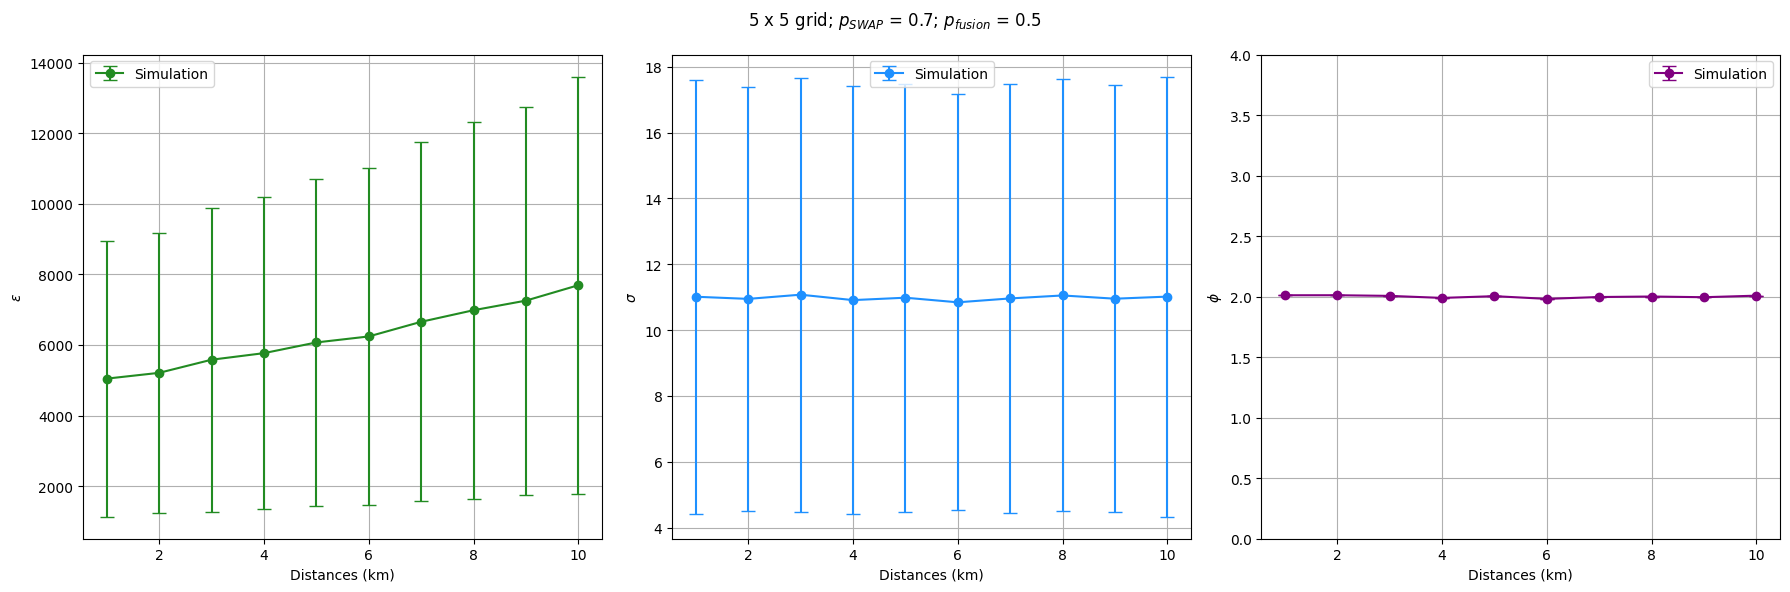

In [9]:
# Number of subplots (one for each entry in the third dimension)
num_entries = 3

# Create subplots
fig, axes = plt.subplots(1, num_entries, figsize=(18, 6), sharex=True)

y_labels = [r"$\epsilon$", r"$\sigma$", r"$\phi$"]

# Define colors for each dataset
colors_classical = ['forestgreen', 'dodgerblue', 'purple']
labels_classical = "Simulation"

# Loop over the third dimension (3 entries)
for i in range(num_entries):
    ax = axes[i]  # Select subplot
    
    # Extract mean and error for classical and quantum data
    mean_classical = simulation_results[0, :, i]
    error_classical = simulation_results[1, :, i]

    # Plot classical data with error bars
    ax.errorbar(distances, mean_classical, yerr=error_classical, fmt='o-', color=colors_classical[i], label=labels_classical, capsize=5)
    
    # Labels and title
    ax.set_xlabel("Distances (km)")
    
    ax.set_ylabel(y_labels[i])
    
    # Grid and legend
    ax.grid(True)
    ax.legend()

# Adjust layout and show the plot
axes[2].set_ylim((0, 4))

plt.suptitle(fr"{vertices} x {vertices} grid; $p_{{SWAP}}$ = {q}; $p_{{fusion}}$ = {k}")
plt.tight_layout()
plt.show()

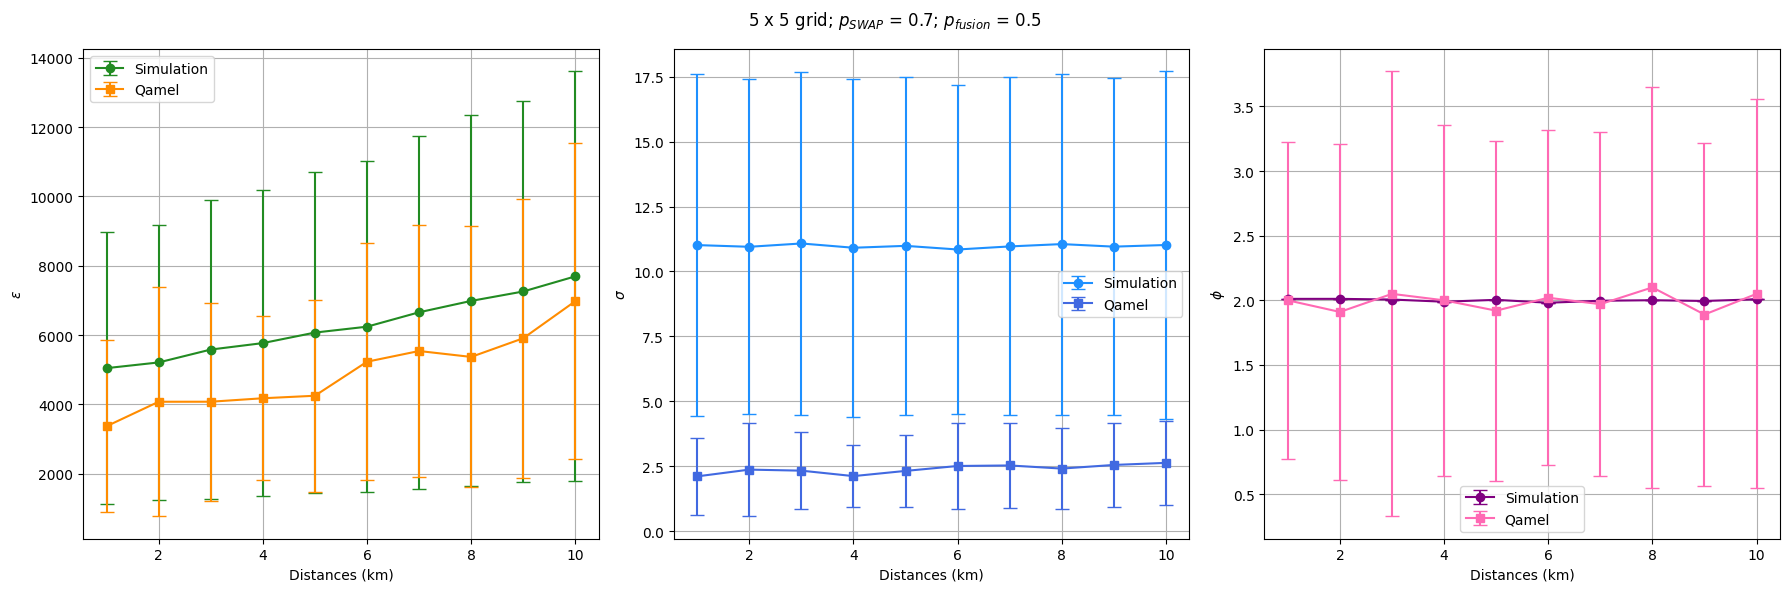

In [10]:
# Number of subplots (one for each entry in the third dimension)
num_entries = 3

# Create subplots
fig, axes = plt.subplots(1, num_entries, figsize=(18, 6), sharex=True)

y_labels = [r"$\epsilon$", r"$\sigma$", r"$\phi$"]

# Define colors for each dataset
colors_classical = ['forestgreen', 'dodgerblue', 'purple']
colors_quantum = ['darkorange', 'royalblue', 'hotpink']
labels_classical = "Simulation"
labels_quantum = "Qamel"

# Loop over the third dimension (3 entries)
for i in range(num_entries):
    ax = axes[i]  # Select subplot
    
    # Extract mean and error for classical and quantum data
    mean_classical = simulation_results[0, :, i]
    error_classical = simulation_results[1, :, i]
    mean_quantum = qamel_results[0, :, i]
    error_quantum = qamel_results[1, :, i]
    
    # Plot classical data with error bars
    ax.errorbar(distances, mean_classical, yerr=error_classical, fmt='o-', color=colors_classical[i], label=labels_classical, capsize=5)
    
    # Plot quantum data with error bars
    ax.errorbar(distances, mean_quantum, yerr=error_quantum, fmt='s-', color=colors_quantum[i], label=labels_quantum, capsize=5)

    # Labels and title
    ax.set_xlabel("Distances (km)")
    
    ax.set_ylabel(y_labels[i])
    
    # Grid and legend
    ax.grid(True)
    ax.legend()

# Adjust layout and show the plot
plt.suptitle(fr"{vertices} x {vertices} grid; $p_{{SWAP}}$ = {q}; $p_{{fusion}}$ = {k}")
plt.tight_layout()
plt.show()


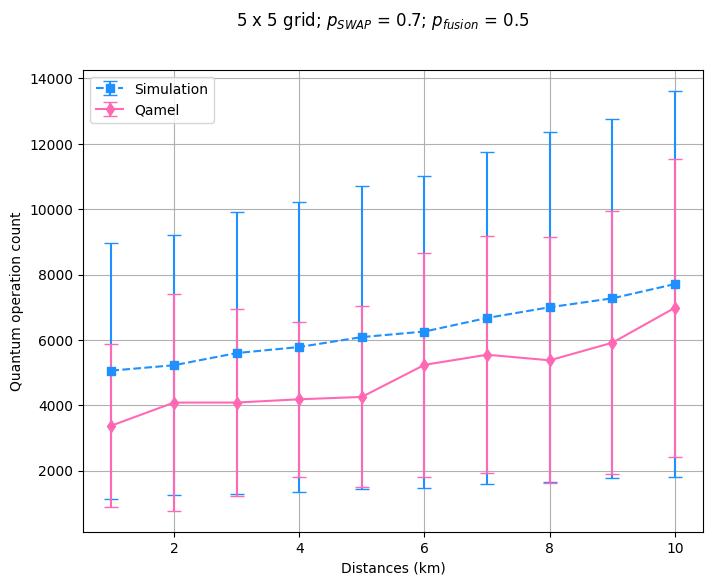

In [11]:
# Sum over the third dimension (axis=2)
sum_mean_classical = np.sum(simulation_results[0, :, :], axis=1)
sum_error_classical = np.sqrt(np.sum(simulation_results[1, :, :]**2, axis=1))  # Error propagation

sum_mean_qamel = np.sum(qamel_results[0, :, :], axis=1)
sum_error_qamel = np.sqrt(np.sum(qamel_results[1, :, :]**2, axis=1))  # Error propagation

# Create a new figure for the combined plot
plt.figure(figsize=(8, 6))

# Plot Classical data (Dodgerblue, Square Markers, Dashed Line)
plt.errorbar(distances, sum_mean_classical, yerr=sum_error_classical, fmt='s--', 
             color='dodgerblue', label="Simulation", capsize=5, markersize=6)

# Plot Qamel data (Hotpink, Diamond Markers, Solid Line)
plt.errorbar(distances, sum_mean_qamel, yerr=sum_error_qamel, fmt='d-', 
             color='hotpink', label="Qamel", capsize=5, markersize=6)

# Labels and title
plt.xlabel("Distances (km)")
plt.ylabel("Quantum operation count")
plt.legend()
plt.grid(True)

# Show the plot
plt.suptitle(fr"{vertices} x {vertices} grid; $p_{{SWAP}}$ = {q}; $p_{{fusion}}$ = {k}")
plt.show()

In [12]:
# Compute the percent improvement arrays
change_operation = (sum_mean_classical - sum_mean_qamel) / sum_mean_classical
change_time_classical = (sim_classical[:, 0] - qamel_results_classical[:, 0]) / sim_classical[:, 0]
change_time_quantum = (sim_quantum[:, 0] - qamel_results_quantum[:, 0]) / sim_quantum[:, 0]

# Compute mean and standard deviation
mean_op = np.mean(change_operation)*100
std_op = np.std(change_operation)*100

mean_classical = np.mean(change_time_classical)*100
std_classical = np.std(change_time_classical)*100

mean_quantum = np.mean(change_time_quantum)*100
std_quantum = np.std(change_time_quantum)*100

# Print results with mean ± std format
print(f"Percent improvement in number of quantum operations: {mean_op:.4f} ± {std_op:.4f}")
print(f"Percent improvement in time spent in classical communication: {mean_classical:.4f} ± {std_classical:.4f}")
print(f"Percent improvement in time spent in quantum communication: {mean_quantum:.4f} ± {std_quantum:.4f}")

Percent improvement in number of quantum operations: 22.4476 ± 6.9214
Percent improvement in time spent in classical communication: 22.4135 ± 7.1247
Percent improvement in time spent in quantum communication: 24.0128 ± 7.1213


In [13]:
#For different p values
segments = 4

probabilities = np.arange(0.1, 1.0, 0.1)

simulation_results = np.zeros(shape = (2, len(probabilities)))

for i, p in enumerate(probabilities):
    _, e_all, p_all, k_all = monte_carlo(segments, sim_count, sim_count, p, q, k, ind = True)
    data = np.array([e_all, p_all, k_all]).mean(axis = 1)
    data_std = np.array([e_all, p_all, k_all]).std(axis = 1)

    simulation_results[0, i] = np.sum(data)
    simulation_results[1, i] = np.sum(data_std) 
    

vertices = segments+1
qamel_results = np.loadtxt(f"S:/Anuj/University College London/Latency for MED protocols/Timing-Multiuser-Protocols/qamel/outputs/results/{vertices}_qamel_results_for_different_p.txt")

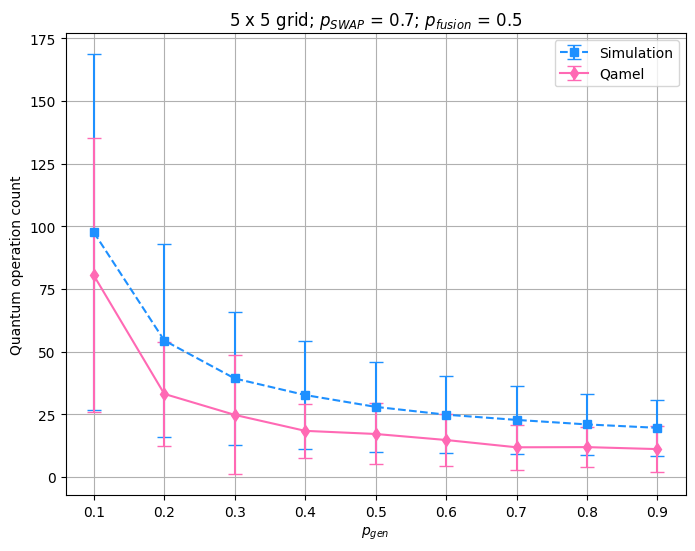

In [14]:
plt.figure(figsize=(8, 6))

# Plot Classical data (Dodgerblue, Square Markers, Dashed Line)
plt.errorbar(probabilities, simulation_results[0], yerr=simulation_results[1], fmt='s--', color='dodgerblue', label="Simulation", capsize=5, markersize=6)

# Plot Qamel data (Hotpink, Diamond Markers, Solid Line)
plt.errorbar(probabilities, qamel_results[0], yerr=qamel_results[1], fmt='d-', color='hotpink', label="Qamel", capsize=5, markersize=6)

# Labels and title
plt.xlabel(r"$p_{gen}$")
plt.ylabel("Quantum operation count")
plt.legend()
plt.grid(True)

# Show the plot
plt.title(fr"{vertices} x {vertices} grid; $p_{{SWAP}}$ = {q}; $p_{{fusion}}$ = {k}")
plt.show()

In [15]:
#For different segments values
p = 0.4

segments = [2, 4, 8]

simulation_results = np.zeros(shape = (2, len(segments)))

for i, s in enumerate(segments):
    _, e_all, p_all, k_all = monte_carlo(s, sim_count, sim_count, p, q, k, ind = True)
    data = np.array([e_all, p_all, k_all]).mean(axis = 1)
    data_std = np.array([e_all, p_all, k_all]).std(axis = 1)

    simulation_results[0, i] = np.sum(data)
    simulation_results[1, i] = np.sum(data_std) 
    
qamel_results = np.loadtxt(f"S:/Anuj/University College London/Latency for MED protocols/Timing-Multiuser-Protocols/qamel/outputs/results/qamel_results_for_different_nodes.txt")

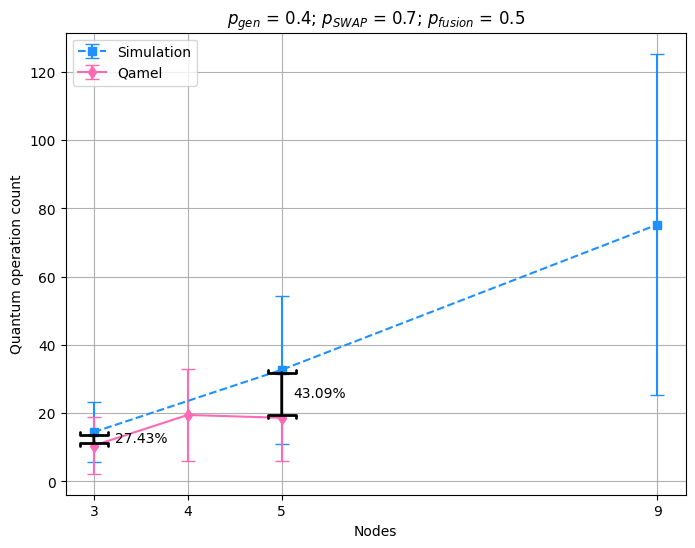

In [16]:
segments_to_nodes = list(map(lambda x: x+1, segments))
nodes = np.arange(3, 6, 1)

plt.figure(figsize=(8, 6))

# Plot Classical data (Dodgerblue, Square Markers, Dashed Line)
plt.errorbar(segments_to_nodes, simulation_results[0], yerr=simulation_results[1], fmt='s--', color='dodgerblue', label="Simulation", capsize=5, markersize=6)

# Plot Qamel data (Hotpink, Diamond Markers, Solid Line)
plt.errorbar(nodes, qamel_results[0], yerr=qamel_results[1], fmt='d-', color='hotpink', label="Qamel", capsize=5, markersize=6)

node_ticks = [3, 4, 5, 9]

x_point = 3
y1 = simulation_results[0][0]  # Value before improvement
y2 = qamel_results[0][0]   # Value after improvement

# Compute the midpoint for annotation
mid_x = x_point
mid_y = (y1 + y2) / 2

# Add annotation text
plt.text(mid_x+0.5, mid_y-1, f"{np.round(((y1-y2)/y1)*100, 2)}%", fontsize=10, color='black', ha='center')

# Add an arrow showing the improvement
plt.annotate("", xy=(x_point, y2), xytext=(x_point, y1),
             arrowprops=dict(arrowstyle="]-[", color='black', lw=2))


x_point = 5
y1 = simulation_results[0][1]  # Value before improvement
y2 = qamel_results[0][2]   # Value after improvement

# Compute the midpoint for annotation
mid_x = x_point
mid_y = (y1 + y2) / 2

# Add annotation text
plt.text(mid_x+0.4, mid_y-1, f"{np.round(((y1-y2)/y1)*100, 2)}%", fontsize=10, color='black', ha='center')

# Add an arrow showing the improvement
plt.annotate("", xy=(x_point, y2), xytext=(x_point, y1),
             arrowprops=dict(arrowstyle="]-[", color='black', lw=2))


# Labels and title
plt.xlabel("Nodes")
plt.xticks(node_ticks)
plt.ylabel("Quantum operation count")
plt.legend()
plt.grid(True)

# Show the plot
plt.title(fr"$p_{{gen}}$ = {p}; $p_{{SWAP}}$ = {q}; $p_{{fusion}}$ = {k}")
plt.show()